In [127]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import time
from tqdm import tqdm

# Importing machine learning libraries
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

# Data Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Dataset

In [2]:
# Load user-level dataset
data = pd.read_csv('Dataset/all_user_data.csv')
print('Number of rows:', data.shape[0], '\nNumber of features:',data.shape[1])
data.head()

Number of rows: 37060 
Number of features: 17


,id,age,gender,country,latitude,longitude,traffic_source,days_since_lo,cancellations,returns,no_orders,no_items,items_per_order,total_spend,avg_order_value,income_category,children_at_home
0,457,65,M,Brazil,-9.945568,-67.835610,Search,85.0,0.0,0.0,1,1,1.0,99.989998,99.989998,high,0.0
1,64231,25,F,Brazil,-9.945568,-67.835610,Search,280.0,0.0,0.0,1,1,1.0,39.950001,39.950001,medium,0.0
2,72187,47,F,Brazil,-9.945568,-67.835610,Search,88.0,0.0,0.0,1,1,1.0,21.000000,21.000000,low,1.0
3,95069,48,M,Brazil,-9.857324,-69.437057,Search,645.0,1.0,1.0,1,1,1.0,39.500000,39.500000,low,1.0
4,21246,62,M,Brazil,-8.325245,-71.553030,Email,77.0,0.0,0.0,2,3,1.5,145.139999,72.570000,high,1.0


In [3]:
# Crosstab by country and gender
pd.crosstab(data.country, data.gender).sort_values('M', ascending = False)

gender,F,M
country,,
China,6663,6835
United States,4465,4424
Brazil,2834,2837
South Korea,1057,1026
France,934,928
United Kingdom,891,925
Germany,841,826
Spain,786,788


## Preprocessing - All countries
### Encoding of categorical values

In [9]:
# Drop columns that won't be used for modelling
data_all = data.drop(columns =['country', 'id'])

# Change income categories to numeric values based on the income level
data_all['income_category'].replace(['none', 'low', 'medium', 'high'],
                                    [0, 1, 2, 3], inplace = True)

# One Hot Encoding of gender and traffic_source
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output = False, drop = 'first')

categorical_columns = ['gender', 'traffic_source']

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(data_all[categorical_columns])

# Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_columns))

# Join tables
data_all = pd.concat([data_all,one_hot_df], axis = 1)

# Drop columns that were encoded
data_all = data_all.drop(columns = ['gender', 'traffic_source'])
data_all.head()

,age,latitude,longitude,days_since_lo,cancellations,returns,no_orders,no_items,items_per_order,total_spend,avg_order_value,income_category,children_at_home,gender_M,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search
0,65,-9.945568,-67.835610,85.0,0.0,0.0,1,1,1.0,99.989998,99.989998,3,0.0,1.0,0.0,0.0,0.0,1.0
1,25,-9.945568,-67.835610,280.0,0.0,0.0,1,1,1.0,39.950001,39.950001,2,0.0,0.0,0.0,0.0,0.0,1.0
2,47,-9.945568,-67.835610,88.0,0.0,0.0,1,1,1.0,21.000000,21.000000,1,1.0,0.0,0.0,0.0,0.0,1.0
3,48,-9.857324,-69.437057,645.0,1.0,1.0,1,1,1.0,39.500000,39.500000,1,1.0,1.0,0.0,0.0,0.0,1.0
4,62,-8.325245,-71.553030,77.0,0.0,0.0,2,3,1.5,145.139999,72.570000,3,1.0,1.0,1.0,0.0,0.0,0.0


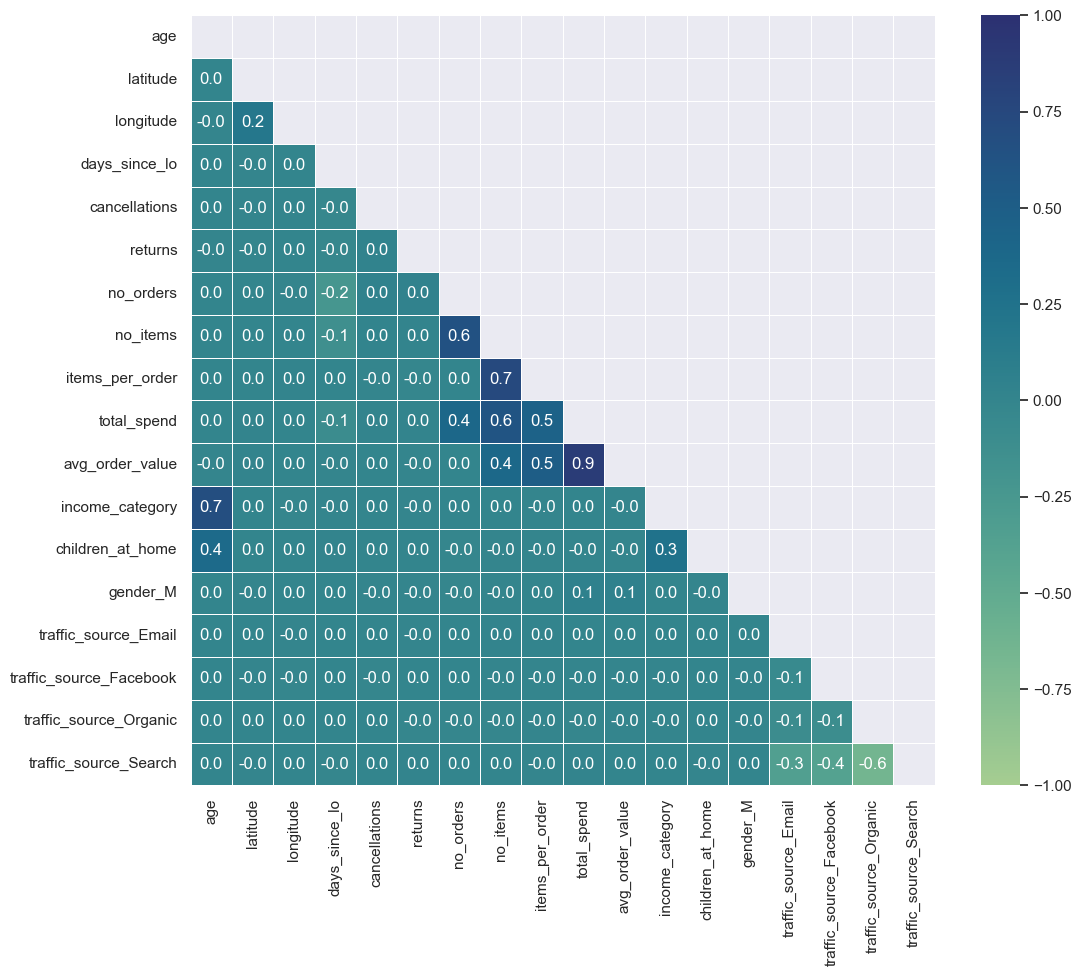

In [10]:
# Correlation matrix for all features
corr = data_all.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (12,10))
sns.heatmap(corr, mask = mask,annot=True, fmt=".1f", 
            cmap="crest", linewidth=.5, vmin=-1, vmax=1)
plt.grid(visible = None)
plt.show()

### Scaling data

In [12]:
# Create scaler: scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_all)

# PCA

Variance explained by top 3 features 0.8165164494958133


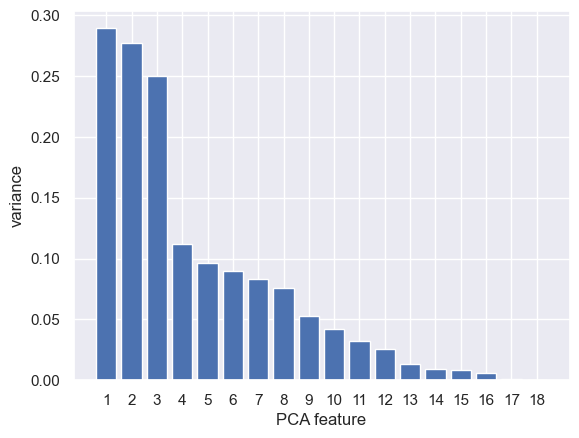

In [19]:
# Create a PCA instance
pca = PCA()

# Fit the PCA to scaled data
pca.fit(data_scaled)

# Explained variance by sum of top 3 features
print('Variance explained by top 3 components', pca.explained_variance_[:3].sum())

# Plot the explained variances
features = range(1, pca.n_components_ +1)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [22]:
# Dimension reduction based on all features with 3 components

# Create a PCA model with 3 components
pca = PCA(n_components = 3)

# Fit the pipeline to scaled data
pca.fit(data_scaled)

# Transform the scaled data
pca_features = pca.transform(data_scaled)

# Print the shape of pca_features
print(pca_features.shape)

(37060, 3)


# Clustering with PCA features

## K-Means

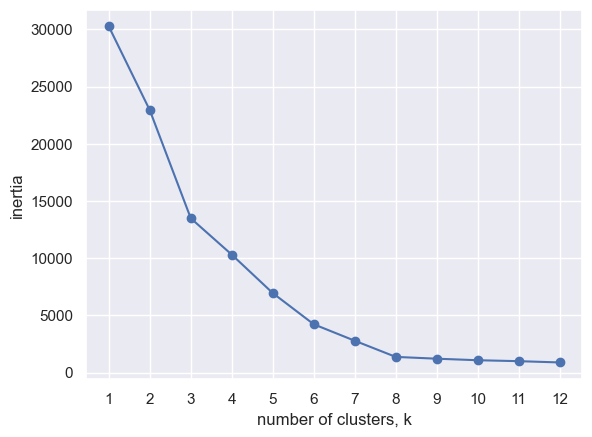

In [23]:
# Training KMeans model with PCA features - evaluation of optimal number of clusters
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, n_init = 'auto')
    
    # Fit model to pca features
    model.fit(pca_features)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

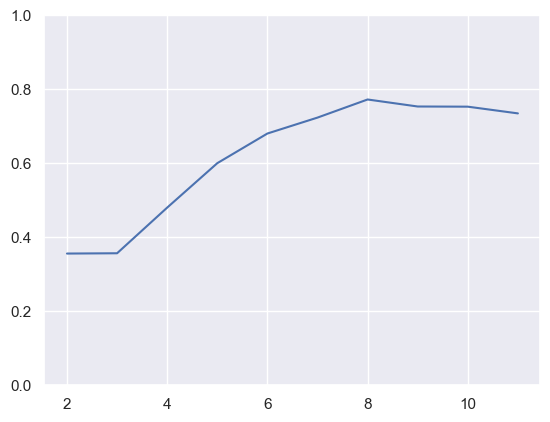

In [24]:
# Evaluation of optimal number of clusters based on silhouette score
ks = range(2, 12)
score = []


for k in ks:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(pca_features)
    
    # Predict the cluster labels
    labels = model.predict(pca_features)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(pca_features, labels, metric='euclidean'))
    
sns.lineplot(x = ks, y = score)
plt.ylim(0, 1)
plt.show()

In [25]:
start_time = time.time()

# Create a KMeans instance with 8 clusters
model = KMeans(n_clusters = 8, n_init = 'auto', random_state = 42)
    
# Fit model to pca features
model.fit(pca_features)

# Predict the cluster labels
labels = model.predict(pca_features)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("KMeans execution time:", execution_time, "seconds")
print("Model's inertia:" , model.inertia_)
print("Model's Silhouette score:" , silhouette_score(pca_features, labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, labels))

KMeans execution time: 0.05194807052612305 seconds
Model's inertia: 1372.1500434670056
Model's Silhouette score: 0.7719615754418019
Model's Davies-Bouldin Index: 0.43890061659199164


In [27]:
# Create dataframe to save labels
labeled_data = data_all

# Save K-Means labels
labeled_data.loc[:, 'km_labels'] = labels

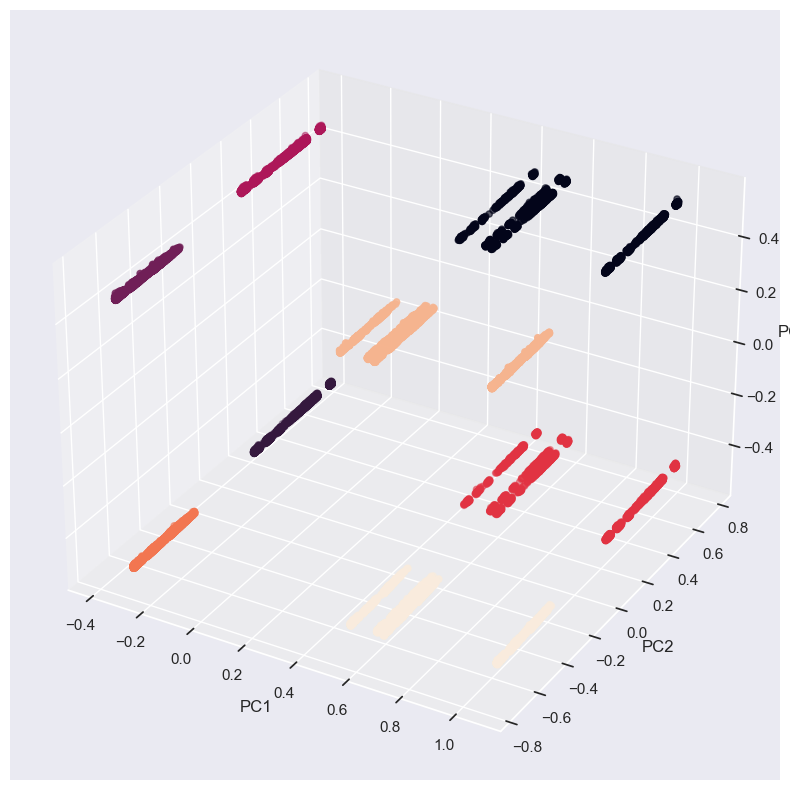

In [28]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

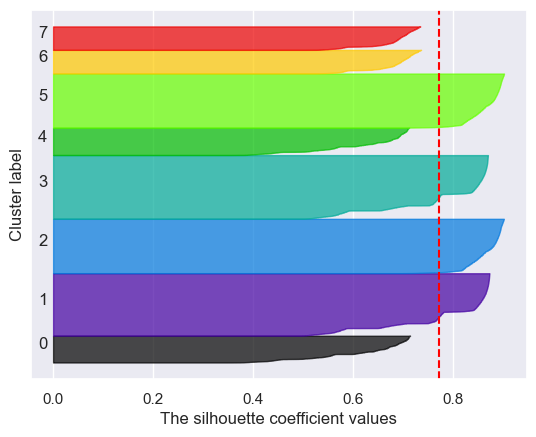

In [31]:
# The silhouette plot 
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
sample_silhouette_values = silhouette_samples(pca_features, labels)
silhouette_avg = silhouette_score(pca_features, labels, metric='euclidean')
clusters = 8

y_lower = 10
for i in range(clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i)/ 8)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for indentation

#plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Hide ticks
plt.show()

# Agglomerative (Hierarchical)
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [32]:
start_time = time.time()

# Create a AgglomerativeClustering instance and fit data
ac_model = AgglomerativeClustering(linkage = 'average').fit(pca_features)

# Predict labels
ac_labels = ac_model.labels_

end_time = time.time()

execution_time = end_time - start_time

# Print performance metrics
print("AgglomerativeClustering execution time:", execution_time, "seconds")
# Number of clusters generated
cluster_no = len(set(ac_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(pca_features, ac_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, ac_labels))

AgglomerativeClustering execution time: 32.08710312843323 seconds
Number of clusters: 2
Model's Silhouette score: 0.3860246355269032
Model's Davies-Bouldin Index: 1.294210578618966


In [33]:
# Save labels to dataframe
labeled_data.loc[:, 'ac_labels'] = ac_labels

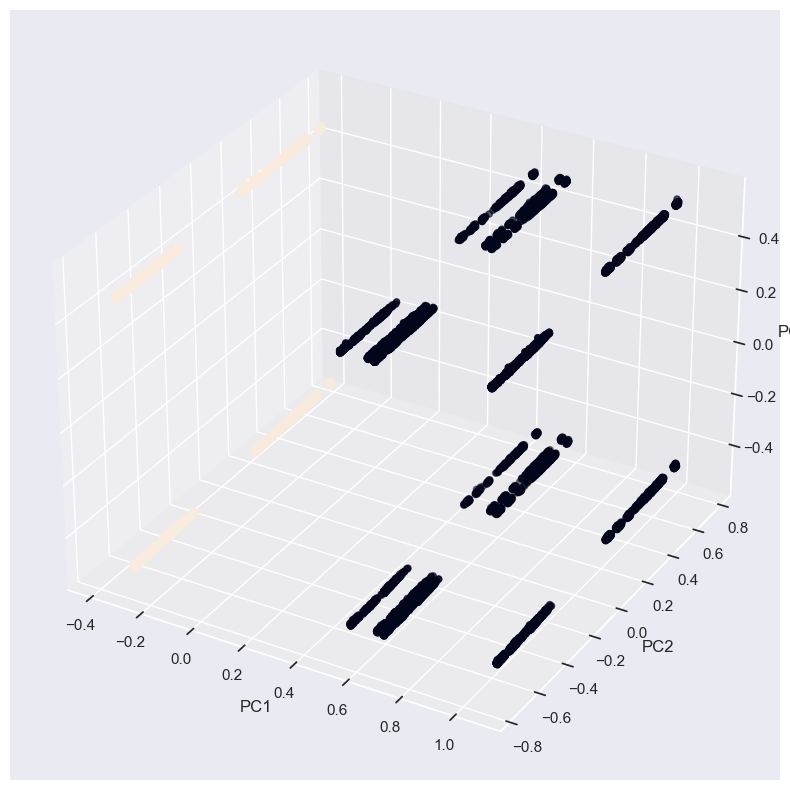

In [34]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = ac_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Mean Shift
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

In [35]:
start_time = time.time()

# Model with the best bandwidth value 
ms_model = MeanShift(bandwidth = 0.4).fit(pca_features)
    
# Predict the cluster labels
ms_labels = ms_model.predict(pca_features)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("MeanShift execution time:", execution_time, "seconds")

# Number of clusters generated
cluster_no = len(set(ms_labels))
print('Number of clusters:', cluster_no)

print("Model's Silhouette score:" , silhouette_score(pca_features, ms_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, ms_labels))

MeanShift execution time: 18.564401149749756 seconds
Number of clusters: 12
Model's Silhouette score: 0.7705142247200552
Model's Davies-Bouldin Index: 0.45874147048005715


In [36]:
# Save labels to dataframe
labeled_data.loc[:, 'ms_labels'] = ms_labels

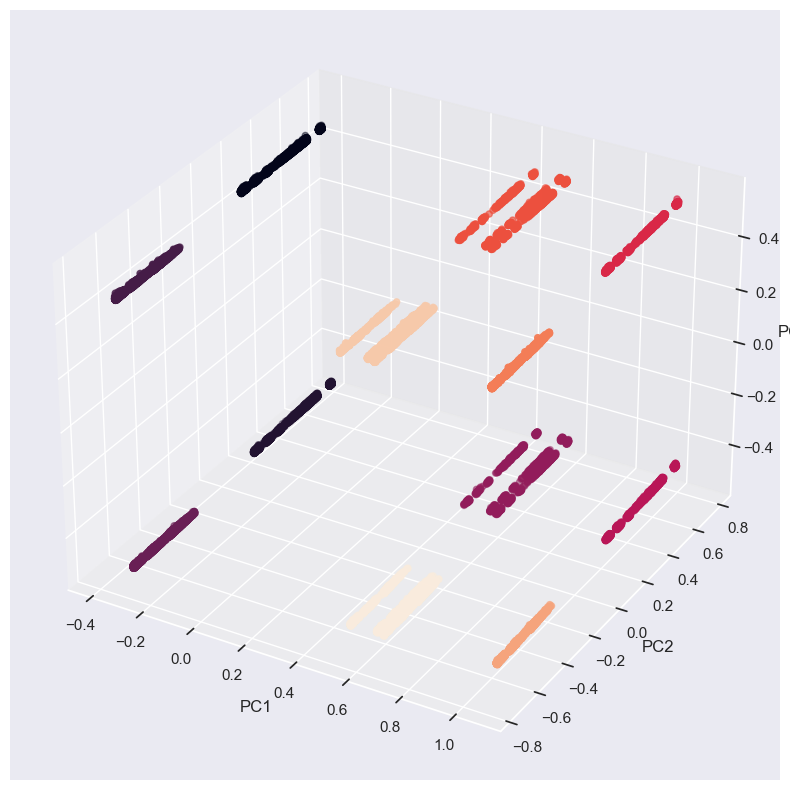

In [37]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = ms_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# DBSCAN
https://scikit-learn.org/dev/auto_examples/cluster/plot_dbscan.html

In [38]:
start_time = time.time()

# Model with the best eps value 
db = DBSCAN(eps=0.3, min_samples=10).fit(pca_features)

# Predict the cluster labels
db_labels = db.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print("Model's Silhouette score:" , silhouette_score(pca_features, db_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, db_labels))

DBSCAN execution time: 1.0014920234680176 seconds
Estimated number of clusters: 12
Estimated number of noise points: 0
Model's Silhouette score: 0.7705142247200552
Model's Davies-Bouldin Index: 0.4587414704800572


In [39]:
# Save labels to dataframe
labeled_data.loc[:, 'db_labels'] = db_labels

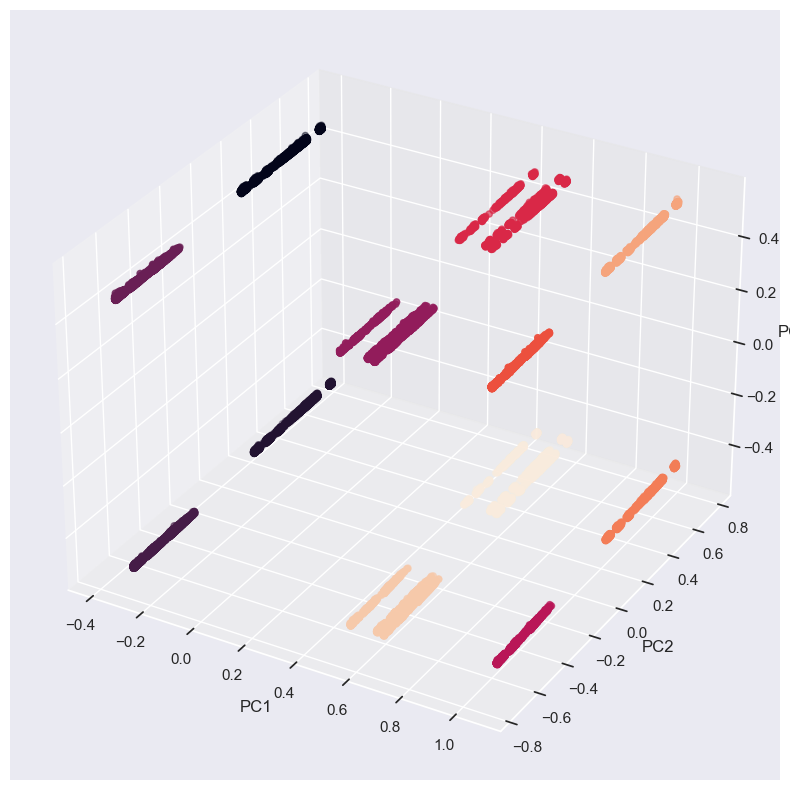

In [40]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = db_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Cluster Analysis for PCA

In [41]:
# Add country column to dataframe with labels
labeled_data['country'] = np.NaN
labeled_data['country'] = data['country']
labeled_data.head()

,age,latitude,longitude,days_since_lo,cancellations,returns,no_orders,no_items,items_per_order,total_spend,...,children_at_home,gender_M,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search,km_labels,ac_labels,ms_labels,db_labels
0,65,-9.945568,-67.835610,85.0,0.0,0.0,1,1,1.0,99.989998,...,0.0,1.0,0.0,0.0,0.0,1.0,3,1,0,0
1,25,-9.945568,-67.835610,280.0,0.0,0.0,1,1,1.0,39.950001,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1
2,47,-9.945568,-67.835610,88.0,0.0,0.0,1,1,1.0,21.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,5,1,3,2
3,48,-9.857324,-69.437057,645.0,1.0,1.0,1,1,1.0,39.500000,...,1.0,1.0,0.0,0.0,0.0,1.0,2,1,2,3
4,62,-8.325245,-71.553030,77.0,0.0,0.0,2,3,1.5,145.139999,...,1.0,1.0,1.0,0.0,0.0,0.0,6,0,10,4


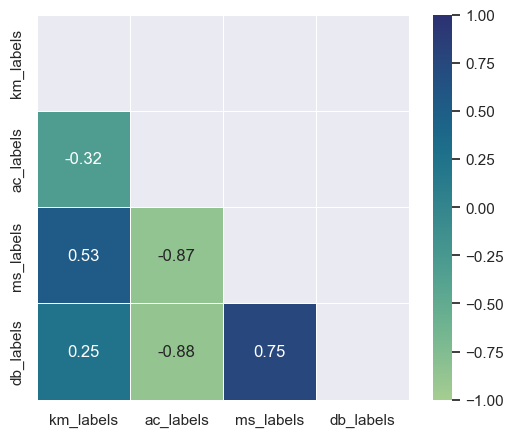

In [89]:
# Correlation matrix for labels
label_columns = ['km_labels', 'ac_labels', 'ms_labels', 'db_labels']
corr = labeled_data[label_columns].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (6,5))
sns.heatmap(corr, mask = mask,annot=True, fmt=".2f", 
            cmap="crest", linewidth=.5, vmin=-1, vmax=1)
plt.grid(visible = None)
plt.show()

In [124]:
# Overall count per cluster for K-Means
labeled_data.groupby('km_labels')[['km_labels']].count()

,km_labels
km_labels,
0,2951
1,6896
2,6006
3,7030
4,3013
5,5976
6,2602
7,2586


In [125]:
# Categorical values by cluster
columns = ['gender_M','traffic_source_Email','traffic_source_Facebook',
          'traffic_source_Organic', 'traffic_source_Search',
          'children_at_home'
          ]
labeled_data.groupby('km_labels')[columns].sum()

,gender_M,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search,children_at_home
km_labels,,,,,,
0,2951.0,505.0,550.0,1501.0,0.0,0.0
1,0.0,0.0,0.0,0.0,6896.0,0.0
2,6006.0,0.0,0.0,0.0,6006.0,6006.0
3,7030.0,0.0,0.0,0.0,7030.0,0.0
4,0.0,468.0,586.0,1503.0,0.0,0.0
5,0.0,0.0,0.0,0.0,5976.0,5976.0
6,2602.0,428.0,521.0,1314.0,0.0,2602.0
7,0.0,425.0,515.0,1307.0,0.0,2586.0


In [126]:
# RFM + age values by cluster
columns = ['age','days_since_lo', 'no_orders','total_spend', 'income_category']
labeled_data.groupby('km_labels')[columns].mean()

,age,days_since_lo,no_orders,total_spend,income_category
km_labels,,,,,
0,35.520502,263.595053,1.238224,113.203626,1.344968
1,35.360209,258.559020,1.238979,101.577251,1.332222
2,47.675491,265.182817,1.222111,110.658462,1.775225
3,35.617354,262.168137,1.235704,114.949819,1.358179
4,35.307003,265.372054,1.236309,98.577956,1.333886
5,47.570783,263.046017,1.239458,102.460736,1.780622
6,47.361645,266.231745,1.212529,109.506568,1.739816
7,47.636504,267.467904,1.226991,99.263933,1.771848


In [115]:
# Crosstab by country and K-Means labels
pd.crosstab(labeled_data.country, labeled_data.km_labels, margins = True)

km_labels,0,1,2,3,4,5,6,7,All
country,,,,,,,,,
Brazil,445,1071,901,1090,485,893,401,385,5671
China,1065,2465,2230,2593,1106,2164,947,928,13498
France,145,371,303,364,130,282,116,151,1862
Germany,138,306,257,316,140,275,115,120,1667
South Korea,177,383,332,376,160,366,141,148,2083
Spain,126,299,267,282,131,260,113,96,1574
United Kingdom,154,339,298,337,141,290,136,121,1816
United States,701,1662,1418,1672,720,1446,633,637,8889
All,2951,6896,6006,7030,3013,5976,2602,2586,37060


# Clusters with RFM Features

In [70]:
# RFM columns
sample_columns = ['no_orders','days_since_lo', 'total_spend']

# Descriptives for RFM features
data_all[sample_columns].describe()

,no_orders,days_since_lo,total_spend
count,37060.000000,37060.000000,37060.000000
mean,1.232731,263.155909,106.805341
std,0.515700,204.219476,114.629940
min,1.000000,1.000000,0.020000
25%,1.000000,84.000000,34.160000
50%,1.000000,216.000000,68.949997
75%,1.000000,416.000000,140.000000
max,4.000000,730.000000,1738.969982


In [47]:
# Create scale and scale data
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(data_all[sample_columns])

## K-means

In [48]:
start_time = time.time()

# Create a KMeans instance with 6 clusters
model = KMeans(n_clusters = 6, n_init = 'auto', random_state = 42)
  
# Fit model to RFM features
model.fit(rfm_scaled)

# Predict the cluster labels: labels
labels = model.predict(rfm_scaled)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("KMeans execution time:", execution_time, "seconds")
print("Model's inertia:" , model.inertia_)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, ac_labels))

KMeans execution time: 0.06186079978942871 seconds
Model's inertia: 536.5417330089879
Model's Silhouette score: 0.4773813977851934
Model's Davies-Bouldin Index: 113.34819332686277


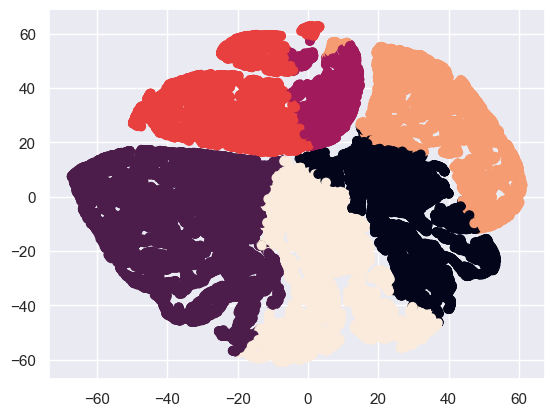

In [49]:
# Create a TSNE instance
model = TSNE(learning_rate = 100)

# Apply fit_transform to RFM features
tsne_features = model.fit_transform(rfm_scaled)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by labels
plt.scatter(xs, ys, c = labels) 
plt.show()

## DBSCAN

In [53]:
start_time = time.time()

# Model with the best eps value 
db = DBSCAN(eps = 0.3, min_samples=10).fit(rfm_scaled)

# Predict labels
db_labels = db.labels_

end_time = time.time()

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

execution_time = end_time - start_time

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, db_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, db_labels))

DBSCAN execution time: 4.289469957351685 seconds
Estimated number of clusters: 4
Estimated number of noise points: 0
Model's Silhouette score: 0.3302077161446522
Model's Davies-Bouldin Index: 1.079902067403091


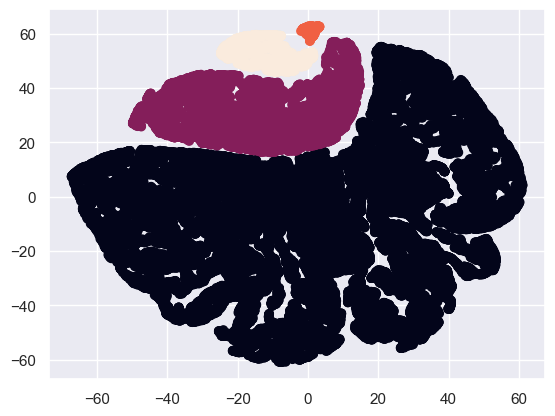

In [54]:
# T-SNE projection coloured by labels
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys, c = db_labels) 
plt.show()

## RFM cluster analysis

In [135]:
# Create dataframe for RFM labels
rfm_df = data_us[sample_columns]

# Add scaled RFM features to the dataframe
rfm_df.loc[:, 'f_scaled'] = rfm_scaled[:, [0]]
rfm_df.loc[:, 'r_scaled'] = rfm_scaled[:, [1]]
rfm_df.loc[:, 'm_scaled'] = rfm_scaled[:, [2]]

# Save K-Means labels
rfm_df.loc[:, 'km_labels'] = labels
# Save DBSCAN labels into the dataframe
rfm_df.loc[:, 'db_labels'] = db_labels


rfm_df.head()

,no_orders,days_since_lo,total_spend,f_scaled,r_scaled,m_scaled,km_labels,db_labels
0,1,85.0,99.989998,0.000000,0.115226,0.057489,1,0
1,1,280.0,39.950001,0.000000,0.382716,0.022962,5,0
2,1,88.0,21.000000,0.000000,0.119342,0.012065,1,0
3,1,645.0,39.500000,0.000000,0.883402,0.022703,4,0
4,2,77.0,145.139999,0.333333,0.104252,0.083453,3,1


### K-means

In [137]:
# Count of customers per cluster
rfm_df[['km_labels', 'no_orders']].groupby('km_labels').count()

,no_orders
km_labels,
0,6392
1,10302
2,2061
3,5016
4,5506
5,7783


In [141]:
# Mean RFM metrics per cluster
rfm_df.groupby('km_labels')[sample_columns].mean()

,no_orders,days_since_lo,total_spend
km_labels,,,
0,1.000000,418.104506,85.425911
1,1.000000,67.121336,86.633593
2,2.090247,356.580786,180.270650
3,2.252990,85.973285,196.940790
4,1.016891,618.159644,87.173983
5,1.000000,233.689837,87.407360


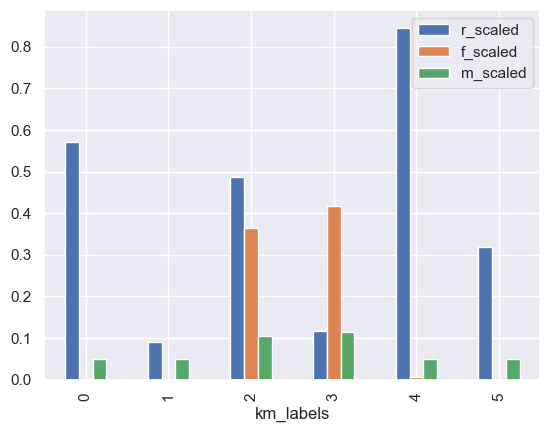

In [138]:
# Bar plot for scaled features by cluster
scaled_columns = ['r_scaled', 'f_scaled', 'm_scaled']
rfm_df.groupby('km_labels')[scaled_columns].mean().plot(kind = 'bar')
plt.show()

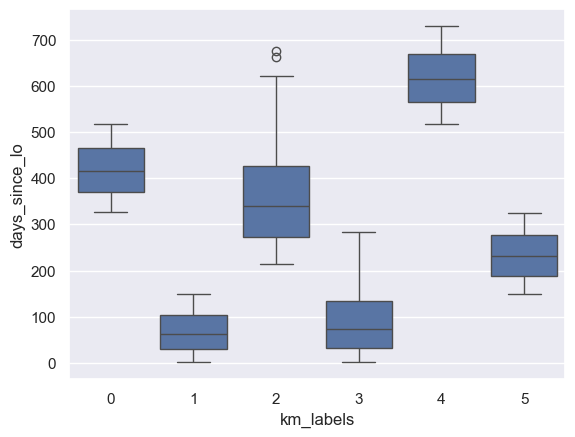

In [139]:
# Boxplot for days since last order
sns.boxplot(data = rfm_df, x = "km_labels", y = "days_since_lo")
plt.show()

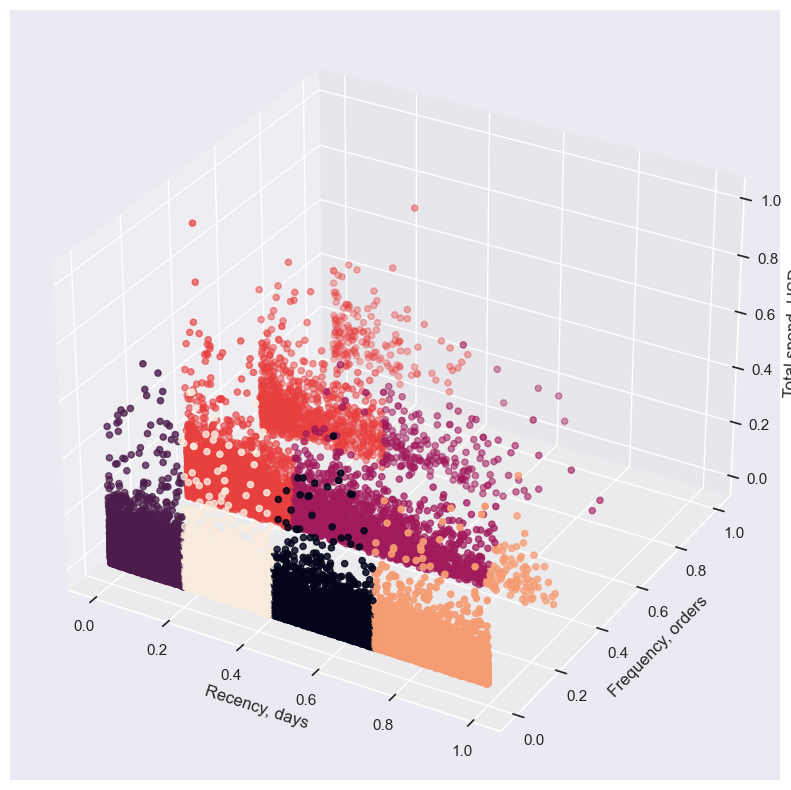

In [133]:
# Visualising data on 3D plot for RFM coloured by K-means labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(16, 10)

ax.scatter(rfm_df['r_scaled'],rfm_df['f_scaled'], rfm_df['m_scaled'], 
           c = rfm_df['km_labels'])
ax.set_xlabel('Recency, days')
ax.set_ylabel('Frequency, orders')
ax.set_zlabel('Total spend, USD')
plt.show()

### DBSCAN

In [130]:
# Count of customers by cluster
rfm_df[['db_labels', 'no_orders']].groupby('db_labels').count()

,no_orders
db_labels,
0,29890
1,5879
2,164
3,1127


In [140]:
# Mean RFM metrics per cluster
rfm_df.groupby('db_labels')[sample_columns].mean()

,no_orders,days_since_lo,total_spend
db_labels,,,
0,1.0,285.265641,86.455579
1,2.0,180.961558,175.708412
2,4.0,86.719512,330.160305
3,3.0,131.209406,254.580879
